In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import subprocess
import cv2
import glob
%matplotlib inline

In [2]:
from opmap.RawCam import RawCam
from opmap.VmemMap import VmemMap
from opmap.PhaseMap import PhaseMap
from opmap.PhaseVarianceMap import PhaseVarianceMap
from opmap.util import makeMovie

# hj map & Ina map & pvmap

In [3]:
width = 10
thres = 0.05
size_h = 300
size_w = 300

data_dirs = [
    '/mnt/recordings/SimulationResults/20170809-1',
    '/mnt/recordings/SimulationResults/20170809-4',
    '/mnt/recordings/SimulationResults/20170810-3',
]



In [4]:
for data_dir in data_dirs:
    
    print data_dir

    save_dir = data_dir.replace( 
        '/SimulationResults/',
        '/AnalysisResult/Seno/simulation/Mahajan/20170812/'
    )
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    length = len( glob.glob(data_dir+ '/vmem*.npy') )

    vm_array = np.zeros((length, size_h, size_w)) 
    hj_array = np.zeros((length, size_h, size_w))
    m_array = np.zeros((length, size_h, size_w))
    Ina = np.zeros((length, size_h, size_w))

    for i in range(length):
        num = '{0:04d}'.format(i)
        a = np.load(  os.path.join( data_dir, 'cell_%s/%s' % (num, 'h.npy')) )
        b = np.load(  os.path.join( data_dir, 'cell_%s/%s' % (num, 'j.npy')) )
        hj_array[i, :, :] = a*b
        vm_array[i, :, :] = np.load( os.path.join( data_dir, 'vmem_%s.npy' % (num)) )
        m_array[i, :, :] = np.load( os.path.join( data_dir, 'cell_%s/%s' % (num, 'm.npy')) )
        Ina[i, :, :] = np.load( os.path.join( data_dir, 'cell_%s/%s' % (num, 'xina.npy')) )

    with open( os.path.join(save_dir,  "array.npz") , 'w') as outf:
        np.savez(
            outf, 
            vm_array = vm_array,
            hj_array = hj_array,
            Ina = Ina
        )

/mnt/recordings/SimulationResults/20170809-1
/mnt/recordings/SimulationResults/20170809-4
/mnt/recordings/SimulationResults/20170810-3


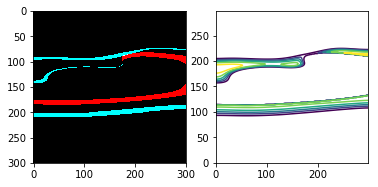

In [26]:

x = np.arange(size_w)
y = np.arange(size_h)
X, Y = np.meshgrid(x, y)


for i in range(400):
    if i < width+1:
        continue
    
    plt.clf()
    
    im_out = np.zeros([size_h, size_w, 3], dtype=np.uint8)
    
    im_out[:, :, 0] = (np.sum((Ina[i-width:i, :, :] < -1), axis=0) > 0) * 255
    
    ans = np.zeros((1, size_h, size_w))
    for j in range(width):
        ans += ((hj_array[i+j-1-width:i+j-width, :, :] < thres) * (hj_array[i+j-width:i+j+1-width, :, :] >= thres))
        
    im_out[:, :, 1] = (ans[0, :, :] > 0) * 255
    im_out[:, :, 2] = (ans[0, :, :] > 0) * 255

    plt.subplot(1,3,1)
    plt.imshow(vm_array[i, :, :], cmap=)
    
    #plt.imsave(os.path.join(save_dir, 'wfwt_{0:0>6}.png'.format(i-width-1)), im_out)    
    plt.subplot(1,3,2)
    plt.imshow(im_out)
    
    
    Z = hj_array[i,:,:] 
    Z = Z[::-1, :]
    plt.subplot(1,3,3)
    plt.contour(X, Y, Z)
    
    plt.gca().set_aspect('equal')    
    plt.savefig(os.path.join(save_dir, 'contour_{0:0>6}.png'.format(i-width-1)))    

In [27]:
subprocess.call(
    'ffmpeg -r 30 -y -i "{0}" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{1}"'.format(
        os.path.join(save_dir, 'contour_%06d.png'),
        os.path.join(save_dir, 'contour.mp4'),
    ),
    shell=True
)

0

# zoom up

In [38]:
width = 10
thres = 0.05
output = '10_005_zoom'

if not os.path.exists('/mnt/recordings/AnalysisResult/Seno/simulation/Mahajan/20170731/FrontAndTail/%s' % output):
    os.makedirs('/mnt/recordings/AnalysisResult/Seno/simulation/Mahajan/20170731/FrontAndTail/%s' % output)


for i in range(400):
    if i < width+1:
        continue
    num = '{0:06d}'.format(i-width-1)
    im_out = np.zeros([200, 200, 3], dtype=np.uint8)
    im_out[:, :, 0] = (np.sum((Ina[i-width:i, :, :] < -1), axis=0) > 0) * 255
    ans = np.zeros((1, 200, 200))
    for j in range(width):
        ans += ((hj_array[i+j-1-width:i+j-width, :, :] < thres) * (hj_array[i+j-width:i+j+1-width, :, :] >= thres))
    im_out[:, :, 1] = (ans[0, :, :] > 0) * 255
    im_out[:, :, 2] = (ans[0, :, :] > 0) * 255
    """
    for j in range(200):
        for k in range(200):
            if (j-100)*(j-100)+(k-135)*(k-135) < 900:
                im_out[j, k, 2] = 255
    """
    plt.imsave('/mnt/recordings/AnalysisResult/Seno/simulation/Mahajan/20170731/FrontAndTail/%s/%s.png' % (output, num), im_out[30:170, :140, :])
subprocess.call('ffmpeg -r 30 -y -i "/mnt/recordings/AnalysisResult/Seno/simulation/Mahajan/20170731/FrontAndTail/{0}/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "/mnt/recordings/AnalysisResult/Seno/simulation/Mahajan/20170731/FrontAndTail/{0}/movie.mp4"'.format(output), shell=True)

0